In [ ]:
import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt
        except:
            pass

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import matplotlib.pyplot as plt

In [4]:
r_pw_seasonal = pd.read_csv('prices.csv')
pd.to_datetime(r_pw_seasonal['start_weekday'])
r_pw_seasonal.head(3)

,year_week,start_weekday,price_apple,price_banana,price_pear,price_orange,price_lemon
0,201931,2019-07-29,90.0,80.0,130.0,100.0,110.0
1,201932,2019-08-05,90.0,80.0,130.0,100.0,110.0
2,201933,2019-08-12,90.0,80.0,130.0,100.0,110.0


In [5]:
M_sp = pd.read_pickle('shop_info.pkl')

In [6]:
C_po = pd.read_pickle('product_rels.pkl')

In [7]:
S = np.arange(len(M_sp))
P = np.array(['apple', 'banana', 'pear', 'orange', 'lemon'])
W = np.arange(24) # Если горизонт планирования не 24 недели — len(r_pw_seasonal))

In [8]:
model = pyo.ConcreteModel()
model.r_pw = pyo.Var(P, W, domain=pyo.NonNegativeReals)

In [9]:
F = sum(model.r_pw[p, w] *
          (M_sp[s][p] * (-(model.r_pw[p, w] / r_pw_seasonal.loc[w, 'price_'+p]) ** 2
                          - 0.075 * (model.r_pw[p, w] / r_pw_seasonal.loc[w, 'price_'+p]) + 2.85) / 1.775
        + sum((r_pw_seasonal.loc[w, 'price_'+o] / model.r_pw[o, w]) ** 2 * C_po[(p, o)] * M_sp[s][o] for o in P))
        for s in S for p in P for w in W)

In [10]:
model.obj = pyo.Objective(expr=F, sense=pyo.maximize)

In [11]:
model.constraints = pyo.ConstraintList()
for p in P:
  for w in W:
    model.constraints.add(0.75 * r_pw_seasonal.loc[w, 'price_'+p] <= model.r_pw[p, w])
    model.constraints.add(model.r_pw[p, w] <= 1.25 * r_pw_seasonal.loc[w, 'price_'+p])

In [12]:
solver = pyo.SolverFactory('ipopt')
res = solver.solve(model, tee=True)
#print([[model.r_pw[p, w].value for p in P] for w in W])

ApplicationError: No executable found for solver 'ipopt'

In [ ]:
model.obj()

718206607.4962041

In [ ]:
optimal_profit = np.array([sum(model.r_pw[p, w].value * \
      (M_sp[s][p] * (-(model.r_pw[p, w].value / r_pw_seasonal.loc[w, 'price_'+p]) ** 2 \
       - 0.075 * (model.r_pw[p, w].value / r_pw_seasonal.loc[w, 'price_'+p]) + 2.85) / 1.775 +
         sum((r_pw_seasonal.loc[w, 'price_'+o] / model.r_pw[o, w].value) ** 2 * C_po[(p, o)] * M_sp[s][o] for o in P))
        for s in S for p in P) for w in W])

In [ ]:
mins = 0.75 * r_pw_seasonal[['price_'+p for p in P]]
maxes = 1.25 * r_pw_seasonal[['price_'+p for p in P]]

In [ ]:
min_profit = np.array([sum(mins.loc[w, 'price_'+p] * \
      (M_sp[s][p] * (-(mins.loc[w, 'price_'+p] / r_pw_seasonal.loc[w, 'price_'+p]) ** 2 \
       - 0.075 * (mins.loc[w, 'price_'+p] / r_pw_seasonal.loc[w, 'price_'+p]) + 2.85) / 1.775 +
         sum((r_pw_seasonal.loc[w, 'price_'+o] / mins.loc[w, 'price_'+o]) ** 2 * C_po[(p, o)] * M_sp[s][o] for o in P))
        for s in S for p in P) for w in W])

In [ ]:
max_profit = np.array([sum(maxes.loc[w, 'price_'+p] * \
      (M_sp[s][p] * (-(maxes.loc[w, 'price_'+p] / r_pw_seasonal.loc[w, 'price_'+p]) ** 2 \
       - 0.075 * (maxes.loc[w, 'price_'+p] / r_pw_seasonal.loc[w, 'price_'+p]) + 2.85) / 1.775 +
         sum((r_pw_seasonal.loc[w, 'price_'+o] / maxes.loc[w, 'price_'+o]) ** 2 * C_po[(p, o)] * M_sp[s][o] for o in P))
        for s in S for p in P) for w in W])

In [ ]:
not_optimal_profit = np.array([sum(r_pw_seasonal.loc[w, 'price_'+p] * \
      (M_sp[s][p] * (-(r_pw_seasonal.loc[w, 'price_'+p] / r_pw_seasonal.loc[w, 'price_'+p]) ** 2 \
       - 0.075 * (r_pw_seasonal.loc[w, 'price_'+p] / r_pw_seasonal.loc[w, 'price_'+p]) + 2.85) / 1.775 +
         sum((r_pw_seasonal.loc[w, 'price_'+o] / r_pw_seasonal.loc[w, 'price_'+o]) ** 2 * C_po[(p, o)] * M_sp[s][o] for o in P))
        for s in S for p in P) for w in W])

In [ ]:
sum(not_optimal_profit)

684522522.1500003

In [ ]:
r_pw_random = pd.DataFrame([[np.random.randint(mins.loc[w, 'price_'+p], maxes.loc[w, 'price_'+p]) for p in P] for w in W], columns=P)

In [ ]:
random_profit = np.array([sum(r_pw_random.loc[w, p] * \
      (M_sp[s][p] * (-(r_pw_random.loc[w, p] / r_pw_seasonal.loc[w, 'price_'+p]) ** 2 \
       - 0.075 * (r_pw_random.loc[w, p] / r_pw_seasonal.loc[w, 'price_'+p]) + 2.85) / 1.775 +
         sum((r_pw_seasonal.loc[w, 'price_'+o] / r_pw_random.loc[w, o]) ** 2 * C_po[(p, o)] * M_sp[s][o] for o in P))
        for s in S for p in P) for w in W])

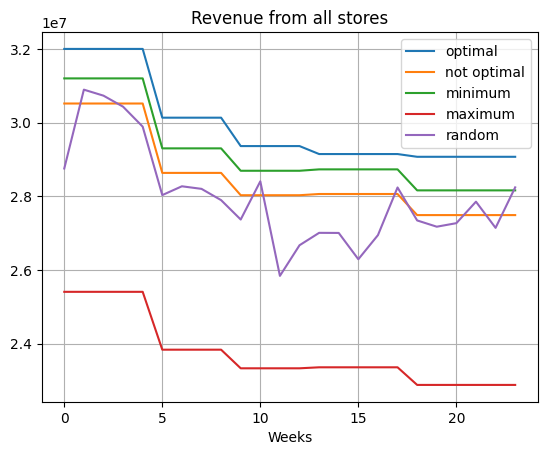

In [ ]:
plt.title('Revenue from all stores')
plt.xlabel('Weeks')
plt.plot(W, optimal_profit, label = 'optimal')
plt.plot(W, not_optimal_profit, label = 'not optimal')
plt.plot(W, min_profit, label = 'minimum')
plt.plot(W, max_profit, label = 'maximum')
plt.plot(W, random_profit, label = 'random')
plt.grid()
plt.legend()